In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy.stats import qmc

In [2]:
var_percentile = 0.05
rng_seed = 10
stock_curr_val = 1e6 * np.ones(4)
fixed_leg_rate = 4.2 / 100
one_bee_pee = 0.01 / 100
swap_notional = 100_000_000
start_date = pd.to_datetime("2023-10-30")

## Data Prep ##

In [3]:
swap_raw = pd.read_excel("hist_data.xlsm", sheet_name="SofrCurve")
aapl_raw = pd.read_excel("hist_data.xlsm", sheet_name="AAPL").set_index("Date")
msft_raw = pd.read_excel("hist_data.xlsm", sheet_name="MSFT").set_index("Date")
f_raw = pd.read_excel("hist_data.xlsm", sheet_name="F").set_index("Date")
bac_raw = pd.read_excel("hist_data.xlsm", sheet_name="BAC").set_index("Date")

In [4]:
swap_raw.head()

,Tenor,T,2022-10-31 00:00:00,2022-11-01 00:00:00,2022-11-02 00:00:00,2022-11-03 00:00:00,2022-11-04 00:00:00,2022-11-07 00:00:00,2022-11-08 00:00:00,2022-11-09 00:00:00,...,2023-10-17 00:00:00,2023-10-18 00:00:00,2023-10-19 00:00:00,2023-10-20 00:00:00,2023-10-23 00:00:00,2023-10-24 00:00:00,2023-10-25 00:00:00,2023-10-26 00:00:00,2023-10-27 00:00:00,2023-10-30 00:00:00
0,1D,0.002778,0.039191,0.039604,0.039948,0.040389,0.045965,0.040224,0.040339,0.040373,...,0.052964,0.053038,0.053050,0.053072,0.053090,0.053105,0.052981,0.053047,0.052989,0.052967
1,1M,0.083333,0.038721,0.039023,0.039286,0.039585,0.042343,0.039258,0.039211,0.039193,...,0.053114,0.053102,0.053086,0.053046,0.053077,0.053084,0.053057,0.053089,0.053040,0.053053
2,2M,0.166667,0.038670,0.038886,0.039100,0.039350,0.038795,0.039460,0.039420,0.039483,...,0.053374,0.053284,0.053226,0.053128,0.053191,0.053202,0.053259,0.053218,0.053185,0.053265
3,3M,0.250000,0.040536,0.040725,0.040852,0.041154,0.040611,0.041424,0.041406,0.041445,...,0.053666,0.053561,0.053454,0.053323,0.053404,0.053424,0.053490,0.053414,0.053368,0.053476
4,6M,0.500000,0.044577,0.044849,0.044884,0.045281,0.045212,0.045455,0.045334,0.045299,...,0.054078,0.053989,0.053758,0.053546,0.053638,0.053690,0.053749,0.053567,0.053486,0.053612


In [5]:
# clean up swap raw
swap_raw.index = swap_raw["T"]
swap_raw.drop(columns=["T"], inplace=True)
swap_raw.drop(columns=["Tenor"], inplace=True)
swap_raw = swap_raw.T

In [6]:
swap_raw.head()

T,0.002778,0.083333,0.166667,0.250000,0.500000,0.750000,1.000000,2.000000,3.000000,4.000000,...,15.000000,16.000000,17.000000,18.000000,19.000000,20.000000,25.000000,30.000000,35.000000,40.000000
2022-10-31 00:00:00,0.039191,0.038721,0.038670,0.040536,0.044577,0.046004,0.046449,0.044583,0.042002,0.040318,...,0.037151,0.037057,0.036907,0.036698,0.036433,0.036111,0.034091,0.032350,0.030552,0.028708
2022-11-01 00:00:00,0.039604,0.039023,0.038886,0.040725,0.044849,0.046448,0.046970,0.045022,0.042344,0.040614,...,0.036802,0.036682,0.036511,0.036287,0.036010,0.035678,0.033645,0.031979,0.030238,0.028478
2022-11-02 00:00:00,0.039948,0.039286,0.039100,0.040852,0.044884,0.046580,0.047203,0.045496,0.042749,0.040868,...,0.036855,0.036701,0.036498,0.036248,0.035953,0.035613,0.033627,0.031936,0.030292,0.028608
2022-11-03 00:00:00,0.040389,0.039585,0.039350,0.041154,0.045281,0.047107,0.047894,0.046594,0.043833,0.041825,...,0.037221,0.037069,0.036886,0.036657,0.036372,0.036022,0.033811,0.032134,0.030407,0.028655
2022-11-04 00:00:00,0.045965,0.042343,0.038795,0.040611,0.045212,0.046752,0.047500,0.046097,0.043385,0.041503,...,0.037687,0.037557,0.037380,0.037152,0.036870,0.036534,0.034424,0.032558,0.030723,0.028933


In [7]:
swap_raw_abs_change = swap_raw.diff().dropna()

In [8]:
swap_raw_abs_change.head()

T,0.002778,0.083333,0.166667,0.250000,0.500000,0.750000,1.000000,2.000000,3.000000,4.000000,...,15.000000,16.000000,17.000000,18.000000,19.000000,20.000000,25.000000,30.000000,35.000000,40.000000
2022-11-01 00:00:00,0.000413,0.000302,0.000216,0.000188,0.000272,0.000444,0.000521,0.000439,0.000342,0.000296,...,-0.000349,-0.000375,-0.000395,-0.000411,-0.000423,-0.000434,-0.000446,-0.000372,-0.000314,-0.000230
2022-11-02 00:00:00,0.000344,0.000262,0.000214,0.000128,0.000035,0.000132,0.000234,0.000474,0.000404,0.000254,...,0.000053,0.000019,-0.000013,-0.000040,-0.000058,-0.000064,-0.000018,-0.000043,0.000054,0.000130
2022-11-03 00:00:00,0.000440,0.000299,0.000250,0.000302,0.000397,0.000527,0.000690,0.001098,0.001085,0.000957,...,0.000366,0.000368,0.000388,0.000409,0.000420,0.000409,0.000184,0.000198,0.000115,0.000047
2022-11-04 00:00:00,0.005576,0.002758,-0.000555,-0.000543,-0.000069,-0.000355,-0.000394,-0.000497,-0.000448,-0.000322,...,0.000466,0.000488,0.000494,0.000495,0.000498,0.000512,0.000613,0.000424,0.000315,0.000278
2022-11-07 00:00:00,-0.005741,-0.003085,0.000665,0.000813,0.000243,0.000437,0.000429,0.000536,0.000499,0.000413,...,0.000431,0.000463,0.000487,0.000504,0.000512,0.000514,0.000498,0.000577,0.000577,0.000562


In [9]:
# clean up swap
aapl_raw.rename(columns={"Adj Close": "aapl_close"}, inplace=True)
msft_raw.rename(columns={"Adj Close": "msft_close"}, inplace=True)
f_raw.rename(columns={"Adj Close": "f_close"}, inplace=True)
bac_raw.rename(columns={"Adj Close": "bac_close"}, inplace=True)
stock_raw = pd.concat([aapl_raw, msft_raw, f_raw, bac_raw], axis=1)
stock_raw = stock_raw

In [10]:
stock_raw.head()

,aapl_close,msft_close,f_close,bac_close
Date,,,,
2022-10-31,152.041122,229.443207,11.974380,34.748581
2022-11-01,149.373917,225.529037,12.001248,34.902847
2022-11-02,143.801514,217.552444,11.696740,34.796783
2022-11-03,137.703613,211.770157,11.875863,34.603954
2022-11-04,137.435455,218.827515,12.099767,35.471703


In [11]:
stock_raw_rel_change = stock_raw.pct_change().dropna()

In [12]:
stock_raw_rel_change.head()

,aapl_close,msft_close,f_close,bac_close
Date,,,,
2022-11-01,-0.017543,-0.017059,0.002244,0.004439
2022-11-02,-0.037305,-0.035368,-0.025373,-0.003039
2022-11-03,-0.042405,-0.026579,0.015314,-0.005542
2022-11-04,-0.001947,0.033326,0.018854,0.025077
2022-11-07,0.003902,0.029270,0.014064,0.005980


In [13]:
# do we really need other rates if we know its 10y annual?
swap_raw = swap_raw.loc[:, 1:10]
swap_raw_abs_change = swap_raw_abs_change.loc[:, 1:10]

In [14]:
# current swap zero rate
curr_swap_rate = swap_raw.loc[start_date]
# current stock prices


curr_stock_price = stock_raw.loc[start_date]
# get the stock count, i.e. stock weights
stock_weights = stock_curr_val / curr_stock_price.to_numpy()

## Moddeling the Joint Distribution of the Daily Risk Factor Changes ##
* For each risk factor, specify how you want to model their changes. As I suggested, one
way is to model the absolute daily changes in the zero rate risk factors and model the
daily relative returns of the stock prices.
* Once the above is specified, follow the approach of each VaR model (parametric/Monte
Carlo/historical) to model the joint distribution of the daily risk factor changes.

For each risk factor, you would need to use the 1-year historical data provided to compute their
daily changes over the 1-year historical period. Using the historical daily changes of the risk
factors, one can then determine the joint distribution of 1-day risk factor changes under each of
the 3 VaR models

* Parametric VaR. The 1-day risk factor changes are assumed to be multivariate-normally
distributed. One can simply estimate the means and covariance matrix of the multivariate
normal distribution using the sample means and convariance matrix calculated from the
historical daily changes.
* Monte Carlo VaR. The 1-day risk factor changes are also assumed to be
multivariate-normally distributed. Hence, one simply follow the same appproach as the
parametric VaR to estimate the means and covariance matrix of the multivariate normal
distribution.
* Historical VaR. The joint distribution of the 1-day risk factor changes is simply given by
the empirical distribution of the 1-year historical sample of daily risk factor changes.
Dr. Tony Wong 4 / 21


## Stock VaR - Parametric ##

This is kinda following the lecture notes. Use the percentage diff

In [15]:
# params
stock_raw_rel_change_mean = stock_raw_rel_change.mean()
stock_raw_rel_change_cov = stock_raw_rel_change.cov()

In [16]:
stock_raw_rel_change_mean

aapl_close    0.000568
msft_close    0.001692
f_close      -0.000619
bac_close    -0.001105
dtype: float64

In [17]:
stock_raw_rel_change_cov

,aapl_close,msft_close,f_close,bac_close
aapl_close,0.000252,0.000183,0.000135,0.000075
msft_close,0.000183,0.000320,0.000134,0.000070
f_close,0.000135,0.000134,0.000508,0.000168
bac_close,0.000075,0.000070,0.000168,0.000268


In [18]:
# stock only VAR
stock_parametric_mean = np.matmul(stock_curr_val, stock_raw_rel_change_mean)
stock_parametric_var = np.matmul(
    np.matmul(stock_curr_val, stock_raw_rel_change_cov), stock_curr_val
)
z_value = norm.ppf(var_percentile)
var_stock = abs(stock_parametric_mean + z_value * np.sqrt(stock_parametric_var))
var_stock

87730.49630401182

## Swap VaR - Parametric ##


Begin with calculating the PV01, we will find the price of the option at T = 0

In [19]:
start_df = pd.DataFrame(curr_swap_rate)
start_df["disc_factor"] = np.exp(-start_df.index * start_df[start_df.columns[0]])

In [20]:
def get_pv_fix(df_with_discfactor, disc_factor_colname, the_fixed_rate):
    total_df = 0
    for x in df_with_discfactor.index:
        # print(x)
        if x in range(1, 11):
            total_df += df_with_discfactor.loc[x, disc_factor_colname]
    print(f"for {disc_factor_colname} sum is {total_df}")
    return total_df * the_fixed_rate

In [21]:
def get_pv_float(df_with_discfactor, disc_factor_colname):
    return 1 - df_with_discfactor.loc[10.0, disc_factor_colname]

In [22]:
pv_fix = get_pv_fix(start_df, "disc_factor", fixed_leg_rate)
pv_float = get_pv_float(start_df, "disc_factor")
pv_total = pv_float - pv_fix
print(pv_total)

for disc_factor sum is 7.897229345697059
0.024429019998463197


we tickle each of the zero rates by 1bp

In [23]:
start_df_tickled = start_df.copy()

In [24]:
start_df_tickled.drop(columns=["disc_factor"], inplace=True)
tickled_pv = []

In [25]:
# this is highly inneficient but it works so stop complaining
for tenor in start_df_tickled.index:
    # add one bee pee
    colname = f"tickled{tenor}"
    colname_disc = f"disc_tickled{tenor}"
    start_df_tickled[colname] = start_df_tickled[start_df_tickled.columns[0]]
    start_df_tickled.loc[tenor, colname] = (
        start_df_tickled.loc[tenor, colname] + one_bee_pee
    )
    start_df_tickled[colname_disc] = np.exp(
        -start_df_tickled.index * start_df_tickled[colname]
    )
    temp_pv_fix = get_pv_fix(start_df_tickled, colname_disc, fixed_leg_rate)
    temp_pv_float = get_pv_float(start_df_tickled, colname_disc)
    temp_pv_total = temp_pv_float - temp_pv_fix
    tickled_pv.append(temp_pv_total)
    start_df_tickled.drop(columns=[colname], inplace=True)

for disc_tickled1.0 sum is 7.8971344407740345
for disc_tickled2.0 sum is 7.897047636249925
for disc_tickled3.0 sum is 7.896967607576092
for disc_tickled4.0 sum is 7.896894427754998
for disc_tickled5.0 sum is 7.896828042102135
for disc_tickled6.0 sum is 7.896768130075951
for disc_tickled7.0 sum is 7.896714290079349
for disc_tickled8.0 sum is 7.896666173612121
for disc_tickled9.0 sum is 7.896623446433613
for disc_tickled10.0 sum is 7.896585780185963


In [26]:
pv01 = tickled_pv - pv_total
pv01_notional = pv01 * swap_notional * 10_000
pv01_notional

array([3.98600677e+06, 7.63179678e+06, 1.09930011e+07, 1.40665536e+07,
       1.68547510e+07, 1.93710561e+07, 2.16323359e+07, 2.36532276e+07,
       2.54477691e+07, 6.70595263e+08])

In [27]:
# params
swap_abs_change_mean = swap_raw_abs_change.mean()
swap_abs_change_cov = swap_raw_abs_change.cov()

In [28]:
# my instinct was to use np.dot, but this is easier to read & understand
swap_parametric_mean = np.matmul(pv01_notional, swap_abs_change_mean)


swap_parametric_var = np.matmul(
    np.matmul(pv01_notional, swap_abs_change_cov), pv01_notional
)


z_value = norm.ppf(var_percentile)
var_swap = abs(swap_parametric_mean + z_value * np.sqrt(swap_parametric_var))

In [29]:
print(f"VaR of swap :{var_swap}; VaR of stock {var_stock}")

VaR of swap :932895.2410759287; VaR of stock 87730.49630401182


## Combined Parametric ? ##

In [51]:
port_sensitivity = []
port_sensitivity.extend(pv01_notional)
port_sensitivity.extend(stock_curr_val)
port_sensitivity

[3986006.767042749,
 7631796.779650201,
 10993001.080650268,
 14066553.566560725,
 16854750.986838862,
 19371056.08657008,
 21632335.943821967,
 23653227.56742172,
 25447769.06476809,
 670595262.5624123,
 1000000.0,
 1000000.0,
 1000000.0,
 1000000.0]

In [52]:
swap_raw_abs_change[swap_raw_abs_change.isna().any(axis=1)]
swap_raw_abs_change.head(20)
result_df = pd.concat([swap_raw_abs_change, stock_raw_rel_change], axis=1).dropna(
    axis=0
)
result_df

,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,aapl_close,msft_close,f_close,bac_close
2022-11-01,0.000521,0.000439,0.000342,0.000296,0.000225,0.000124,0.000029,-0.000043,-9.724439e-05,-0.000144,-0.017543,-0.017059,0.002244,0.004439
2022-11-02,0.000234,0.000474,0.000404,0.000254,0.000153,0.000118,0.000109,0.000099,8.994989e-05,0.000091,-0.037305,-0.035368,-0.025373,-0.003039
2022-11-03,0.000690,0.001098,0.001085,0.000957,0.000832,0.000761,0.000704,0.000624,5.446595e-04,0.000495,-0.042405,-0.026579,0.015314,-0.005542
2022-11-04,-0.000394,-0.000497,-0.000448,-0.000322,-0.000204,-0.000116,-0.000038,0.000045,1.258218e-04,0.000192,-0.001947,0.033326,0.018854,0.025077
2022-11-07,0.000429,0.000536,0.000499,0.000413,0.000332,0.000313,0.000328,0.000342,3.452884e-04,0.000339,0.003902,0.029270,0.014064,0.005980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-24,0.000114,0.000371,0.000417,0.000343,0.000257,0.000165,0.000083,0.000032,2.757643e-07,-0.000027,0.002543,0.003674,-0.007840,-0.003911
2023-10-25,0.000150,0.000393,0.000596,0.000743,0.000894,0.000981,0.001022,0.001051,1.077486e-03,0.001100,-0.013492,0.030678,0.013169,0.003141
2023-10-26,-0.000410,-0.000747,-0.000950,-0.001055,-0.001114,-0.001124,-0.001102,-0.001073,-1.046232e-03,-0.001028,-0.024606,-0.037514,-0.016464,0.022309
2023-10-27,-0.000129,-0.000286,-0.000361,-0.000339,-0.000324,-0.000257,-0.000166,-0.000093,-3.667796e-05,0.000011,0.007969,0.005856,-0.122467,-0.036371


In [53]:
combined_mean = result_df.mean()
combined_var = result_df.cov()

In [57]:
# my instinct was to use np.dot, but this is easier to read & understand
port_mean = np.matmul(port_sensitivity, combined_mean)
port_var = np.matmul(np.matmul(port_sensitivity, combined_var), port_sensitivity)
z_value = norm.ppf(var_percentile)
var_port = abs(port_mean + z_value * np.sqrt(port_var))
var_port

936889.2562434177

## MONTE CARLO - FUL REEVAL ##

In [37]:
stock_count = len(stock_raw_rel_change.columns)
swap_count = len(swap_raw_abs_change.columns)

In [38]:
# whatever at this point
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.qmc.Sobol.html
def random_sobol_points(dimensions, power):
    simulation = qmc.Sobol(d=dimensions, scramble=False)
    simulation = simulation.random_base2(m=power)
    simulation = np.delete(simulation, 0, axis=0)
    return simulation


def inverse_cdf(values, my_mean, my_std):
    return norm.ppf(values, loc=my_mean, scale=my_std)

In [39]:
# stock monte carlo point generation
stock_raw_rel_cholesky = np.linalg.cholesky(stock_raw_rel_change.corr().to_numpy())
stock_rand_points = random_sobol_points(stock_count, 18)
rand_normal_gen_stock = inverse_cdf(
    stock_rand_points, stock_raw_rel_change.mean(), stock_raw_rel_change.std()
)
correlated_standard_normals_stock = np.matmul(
    stock_raw_rel_cholesky, rand_normal_gen_stock.T
).T

In [40]:
# stock only monte carlo ?
stock_simulated_returns = correlated_standard_normals_stock + 1
stock_simulated_prices = stock_simulated_returns * curr_stock_price.to_numpy()
stock_simulated_port = stock_weights * stock_simulated_prices
stock_simulated_pnl = stock_simulated_port - 1_000_000
df_stock_simulated_pnl = pd.DataFrame(stock_simulated_pnl)
stock_reval_total = df_stock_simulated_pnl.sum(axis=1)
var_stock_mc_reval = stock_reval_total.quantile(var_percentile)
print(type(stock_reval_total))

<class 'pandas.core.series.Series'>


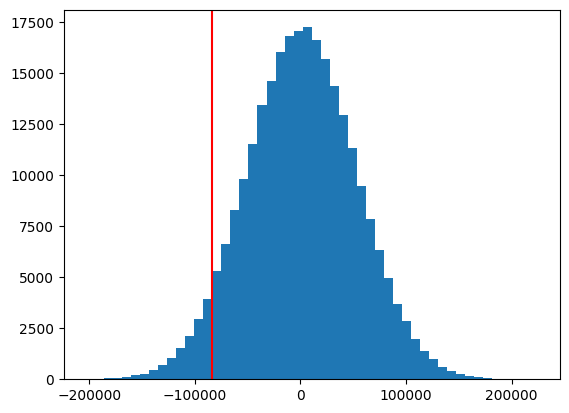

In [41]:
plt.hist(stock_reval_total, bins=50)
plt.axvline(var_stock_mc_reval, color="red")

In [42]:
swap_raw_abs_change

T,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0
2022-11-01,0.000521,0.000439,0.000342,0.000296,0.000225,0.000124,0.000029,-0.000043,-9.724439e-05,-0.000144
2022-11-02,0.000234,0.000474,0.000404,0.000254,0.000153,0.000118,0.000109,0.000099,8.994989e-05,0.000091
2022-11-03,0.000690,0.001098,0.001085,0.000957,0.000832,0.000761,0.000704,0.000624,5.446595e-04,0.000495
2022-11-04,-0.000394,-0.000497,-0.000448,-0.000322,-0.000204,-0.000116,-0.000038,0.000045,1.258218e-04,0.000192
2022-11-07,0.000429,0.000536,0.000499,0.000413,0.000332,0.000313,0.000328,0.000342,3.452884e-04,0.000339
...,...,...,...,...,...,...,...,...,...,...
2023-10-24,0.000114,0.000371,0.000417,0.000343,0.000257,0.000165,0.000083,0.000032,2.757643e-07,-0.000027
2023-10-25,0.000150,0.000393,0.000596,0.000743,0.000894,0.000981,0.001022,0.001051,1.077486e-03,0.001100
2023-10-26,-0.000410,-0.000747,-0.000950,-0.001055,-0.001114,-0.001124,-0.001102,-0.001073,-1.046232e-03,-0.001028
2023-10-27,-0.000129,-0.000286,-0.000361,-0.000339,-0.000324,-0.000257,-0.000166,-0.000093,-3.667796e-05,0.000011


In [43]:
# swap monte carlo point generation
swap_raw_rel_cholesky = np.linalg.cholesky(swap_raw_abs_change.corr().to_numpy())
swap_rand_points = random_sobol_points(swap_count, 18)
rand_normal_gen_swap = inverse_cdf(
    swap_rand_points, swap_raw_abs_change.mean(), swap_raw_abs_change.std()
)
print(rand_normal_gen_swap.shape)
# ALRIGHT ALRIGHT FINE I FOLLOW UR SHEETS AAAAA
correlated_standard_normals_swap = np.matmul(
    swap_raw_rel_cholesky, rand_normal_gen_swap.T
).T

(262143, 10)


In [59]:
# swap only monte carlo
df_swap_simulated_rates = pd.DataFrame(
    curr_swap_rate.to_numpy() + correlated_standard_normals_swap,
    columns=curr_swap_rate.index,
)
for x in df_swap_simulated_rates.columns:
    df_swap_simulated_rates[x] = np.exp(-df_swap_simulated_rates[x].astype(float) * (x))
# ok this becomes disc factor but fuck
swap_simulated_disc = df_swap_simulated_rates.to_numpy()
swap_simulated_pv = []
for i in range(len(swap_simulated_disc)):
    temp_pv_fix = sum(swap_simulated_disc[i]) * fixed_leg_rate
    temp_pv_float = 1 - swap_simulated_disc[i][-1]
    temp_pv_total = temp_pv_float - temp_pv_fix
    swap_simulated_pv.append(temp_pv_total)
simulated_swap_pnl = (swap_simulated_pv - pv_total) * swap_notional
swap_mc_reval_total = pd.Series(simulated_swap_pnl)
var_swap_mc_reval = swap_mc_reval_total.quantile(var_percentile)
var_swap_mc_reval

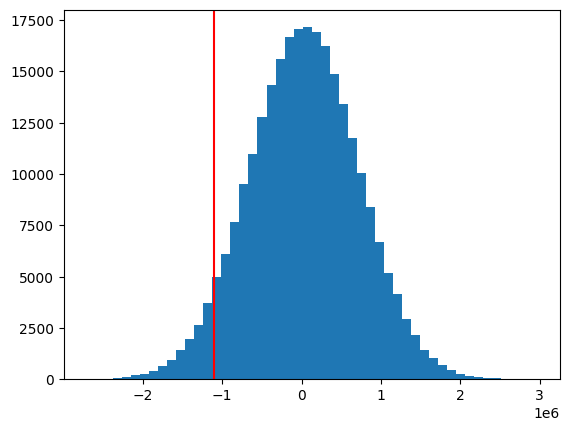

In [49]:
# swap only monte carlo ?
plt.hist(swap_mc_reval_total, 50)
plt.axvline(var_swap_mc_reval, color="red")

## Combined ##

In [65]:
# does this mean we just combine pnl for the whole protfolio?
port_mc_reval_total = stock_reval_total + swap_mc_reval_total
var_port_mc_reval = port_mc_reval_total.quantile(var_percentile)
var_port_mc_reval

-1183072.2934101522

In [62]:
# swap only monte carlo ?
plt.hist(port_mc_reval_total, 50)
plt.axvline(var_port_mc_reval, color="red")

0         3.347374e+04
1        -1.169996e+05
2         1.836413e+05
3        -9.356446e+04
4         8.487877e+05
              ...     
262138    8.316338e+05
262139   -1.881949e+06
262140   -1.085522e+05
262141    1.705734e+05
262142   -1.748934e+06
Length: 262143, dtype: float64